# Testing clustering by compounds receieved before creating Circos plots

In [585]:
import pandas as pd
import reframed
import os
import json
import shutil
import copy
import matplotlib.pyplot as plt
import sys 
sys.path.append('../functions/')

import translation_dicts
import general_functions as general_func
import colors_MAGs as color_func

In [586]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [587]:
import steadiercom_plotting_functions as steadier_plot_func

import steadiercom_data_processing as steadier_data_func

In [588]:

source_dict = {'Marshland': 'M', 'Compost_Digestate': 'CD', 'Cow_Manure': 'CM'}

In [589]:
met_chebi_class = pd.read_csv("../output/met_chebi_class.tsv",index_col=0,sep="\t")
met_chebi_class.head(2)

,chebi id,chebi class,self defined super class
M_12ppd__S_e,CHEBI:26191,polyol,other
M_26dap__M_e,CHEBI:33709,amino acid,amino acids and derivatives


In [590]:
all_mags_paper = general_func.read_allmags_data()

### Color palette

**Phyla**

In [591]:

phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()


**Metabolites**

In [592]:
chebi_lut, chebi_interesting, chebi_colors_ser = color_func.chebi_rxn_color_func(rxn_based=False)


**steadiercom to mag translation (really only interested in MAGs_steadycom_dict)**

In [593]:
phyla_groups,mag2phyla_dict,MAGs_steadycom_dict = steadier_data_func.find_members(steadiercom_crossfeeding_all,all_mags_paper)


## Use hierarchical clustering to find order of elements. 

In [594]:
steadiercom_crossfeeding_all = pd.read_csv("../output/steadiercom_single_sim_0.1.3/steadiercom_crossfeeding_basic.tsv",sep="\t",index_col=(0,1))


**Add super_class**

In [595]:
interesting_super_classes =list(chebi_interesting["self defined super class"].dropna().unique())

steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all.copy()

steadiercom_crossfeeding_all_copy.loc[:,"super_class"]= steadiercom_crossfeeding_all_copy.apply(steadier_plot_func.assign_super_class,axis=1).copy()

**Select community**

In [624]:
test = steadiercom_crossfeeding_all_copy.xs("CD_P").copy()
test = test.dropna().copy()


relevant_super_classes = list(set(test.super_class.unique())-{"other"})
test = test[test.super_class.isin(relevant_super_classes)].copy()

**NB: Cutoff for more interpretable results**

In [625]:
test = test[test.mass_rate>1e-3].copy()

test

,donor,receiver,compound,rate,mass_rate,super_class
38,CH15_bin_16,CH15_bin_0,M_acald_e,0.038297,0.001687,alcohols and aldehydes
39,CH15_bin_16,CH15_bin_6,M_acald_e,0.023019,0.001014,alcohols and aldehydes
84,CH15_bin_23,CH15_bin_0,M_co2_e,0.031177,0.001372,gases
104,CH15_bin_16,CH15_bin_0,M_co2_e,0.028016,0.001233,gases
174,CH15_bin_0,CH15_bin_7,M_gal_e,0.022771,0.004102,simple sugars
175,CH15_bin_0,CH15_bin_6,M_gal_e,0.008463,0.001525,simple sugars
176,CH15_bin_0,CH15_bin_17,M_gal_e,0.009211,0.001659,simple sugars
177,CH15_bin_0,CH15_bin_5,M_gal_e,0.005987,0.001079,simple sugars
181,CH15_bin_7,CH15_bin_8,M_glc__D_e,0.012107,0.002181,simple sugars
484,CH15_bin_6,CH15_bin_16,M_glyald_e,0.018909,0.001703,simple sugars


**create matrix for clustering**

In [626]:
data = test.groupby(["receiver","compound"]).sum()["mass_rate"].unstack().fillna(0)
data

compound,M_acald_e,M_co2_e,M_gal_e,M_glc__D_e,M_glyald_e,M_pta_e
receiver,,,,,,
CH15_bin_0,0.001687,0.002605,0.000000,0.000000,0.000000,0.000000
CH15_bin_13,0.000000,0.000000,0.000000,0.000000,0.000000,0.001253
CH15_bin_16,0.000000,0.000000,0.000000,0.000000,0.001703,0.000000
CH15_bin_17,0.000000,0.000000,0.001659,0.000000,0.000000,0.000000
CH15_bin_2,0.000000,0.000000,0.000000,0.000000,0.001103,0.000000
CH15_bin_5,0.000000,0.000000,0.001079,0.000000,0.000000,0.000000
CH15_bin_6,0.001014,0.000000,0.001525,0.000000,0.000000,0.000000
CH15_bin_7,0.000000,0.000000,0.004102,0.000000,0.000000,0.000000
CH15_bin_8,0.000000,0.000000,0.000000,0.002181,0.000000,0.000000


In [627]:
from scipy.cluster.hierarchy import dendrogram, linkage,leaves_list
from scipy.spatial.distance import pdist
import sklearn

**Alternative 1: normalised for total uptake of each respective mag**

In [628]:
normalised = sklearn.preprocessing.normalize(data,axis=0)

In [629]:
linkage_data = linkage(normalised,method="ward",metric="euclidean")

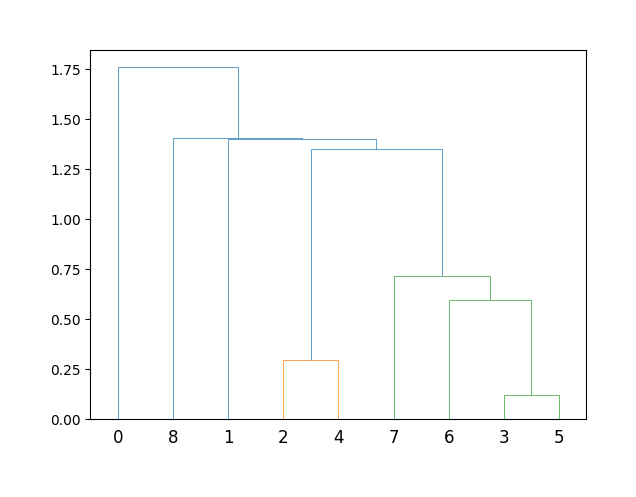

In [630]:
dendrogram(linkage_data)
plt.show()

**Alternative 2: no normalisation**

In [631]:
linkage_data = linkage(data,method="ward",metric="euclidean")

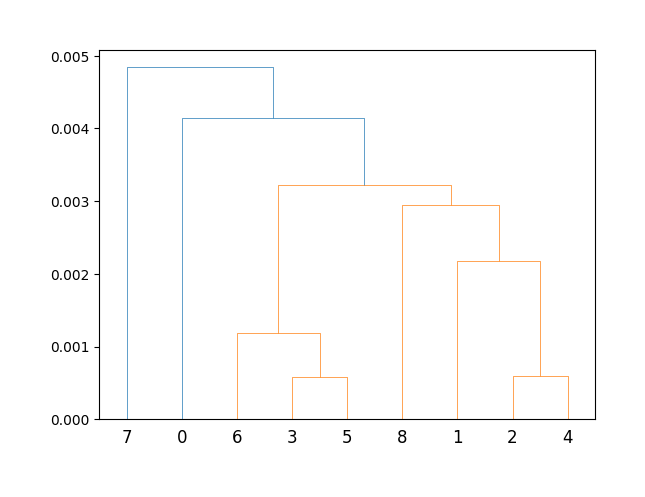

In [632]:
dendrogram(linkage_data)
plt.show()

**find order of mags**

In [633]:
order = leaves_list(linkage_data)
order_mags =data.index[order].values

**Sort matrix according to this order**

In [634]:
test_copy = test.copy()

test_copy.receiver = test_copy.receiver.astype("category")

test_copy.receiver = test_copy.receiver.cat.set_categories(order_mags)

test_copy.sort_values("receiver")

,donor,receiver,compound,rate,mass_rate,super_class
174,CH15_bin_0,CH15_bin_7,M_gal_e,0.022771,0.004102,simple sugars
38,CH15_bin_16,CH15_bin_0,M_acald_e,0.038297,0.001687,alcohols and aldehydes
84,CH15_bin_23,CH15_bin_0,M_co2_e,0.031177,0.001372,gases
104,CH15_bin_16,CH15_bin_0,M_co2_e,0.028016,0.001233,gases
39,CH15_bin_16,CH15_bin_6,M_acald_e,0.023019,0.001014,alcohols and aldehydes
175,CH15_bin_0,CH15_bin_6,M_gal_e,0.008463,0.001525,simple sugars
176,CH15_bin_0,CH15_bin_17,M_gal_e,0.009211,0.001659,simple sugars
177,CH15_bin_0,CH15_bin_5,M_gal_e,0.005987,0.001079,simple sugars
181,CH15_bin_7,CH15_bin_8,M_glc__D_e,0.012107,0.002181,simple sugars
499,CH15_bin_12,CH15_bin_13,M_pta_e,0.012395,0.001253,fatty acids


### Plot results

In [635]:
mags_community = list(order_mags)+list(set(test.donor.values)-set(test.receiver.values))

In [636]:
links = []

member_index = []

for index,row in test_copy.iterrows():
    link = []

    # Donor
    donor = MAGs_steadycom_dict[row.donor]
            #phylum_donor = mag2phyla_dict[donor]
    donor_index = 0 #list(order_mags).index(row.donor)

    member_index.append((donor_index,donor))
    # Receiver
    receiver = MAGs_steadycom_dict[row.receiver]
            #phylum_receiver = mag2phyla_dict[receiver]
    receiver_index = 0 #list(order_mags).index(row.receiver)
    member_index.append((receiver_index,receiver))

    flux_g = row.mass_rate

    if flux_g<1e-3:
        continue

    if flux_g>0.01:
        ratio = 1

    else:
        ratio = flux_g/0.01

    lower_donor = donor_index + 0.48 - 0.4*ratio
    upper_donor = donor_index + 1 - 0.48 + 0.4*ratio

    lower_receiver = receiver_index + 0.48 - 0.4*ratio
    upper_receiver = receiver_index + 1 - 0.48 + 0.4*ratio

    link.append((donor,lower_donor,upper_donor))
    link.append((receiver,lower_receiver,upper_receiver))



    link.append(flux_g)
    link.append(row.compound)
    links.append(link)

    member_index = list(set(member_index))

#links,member_index

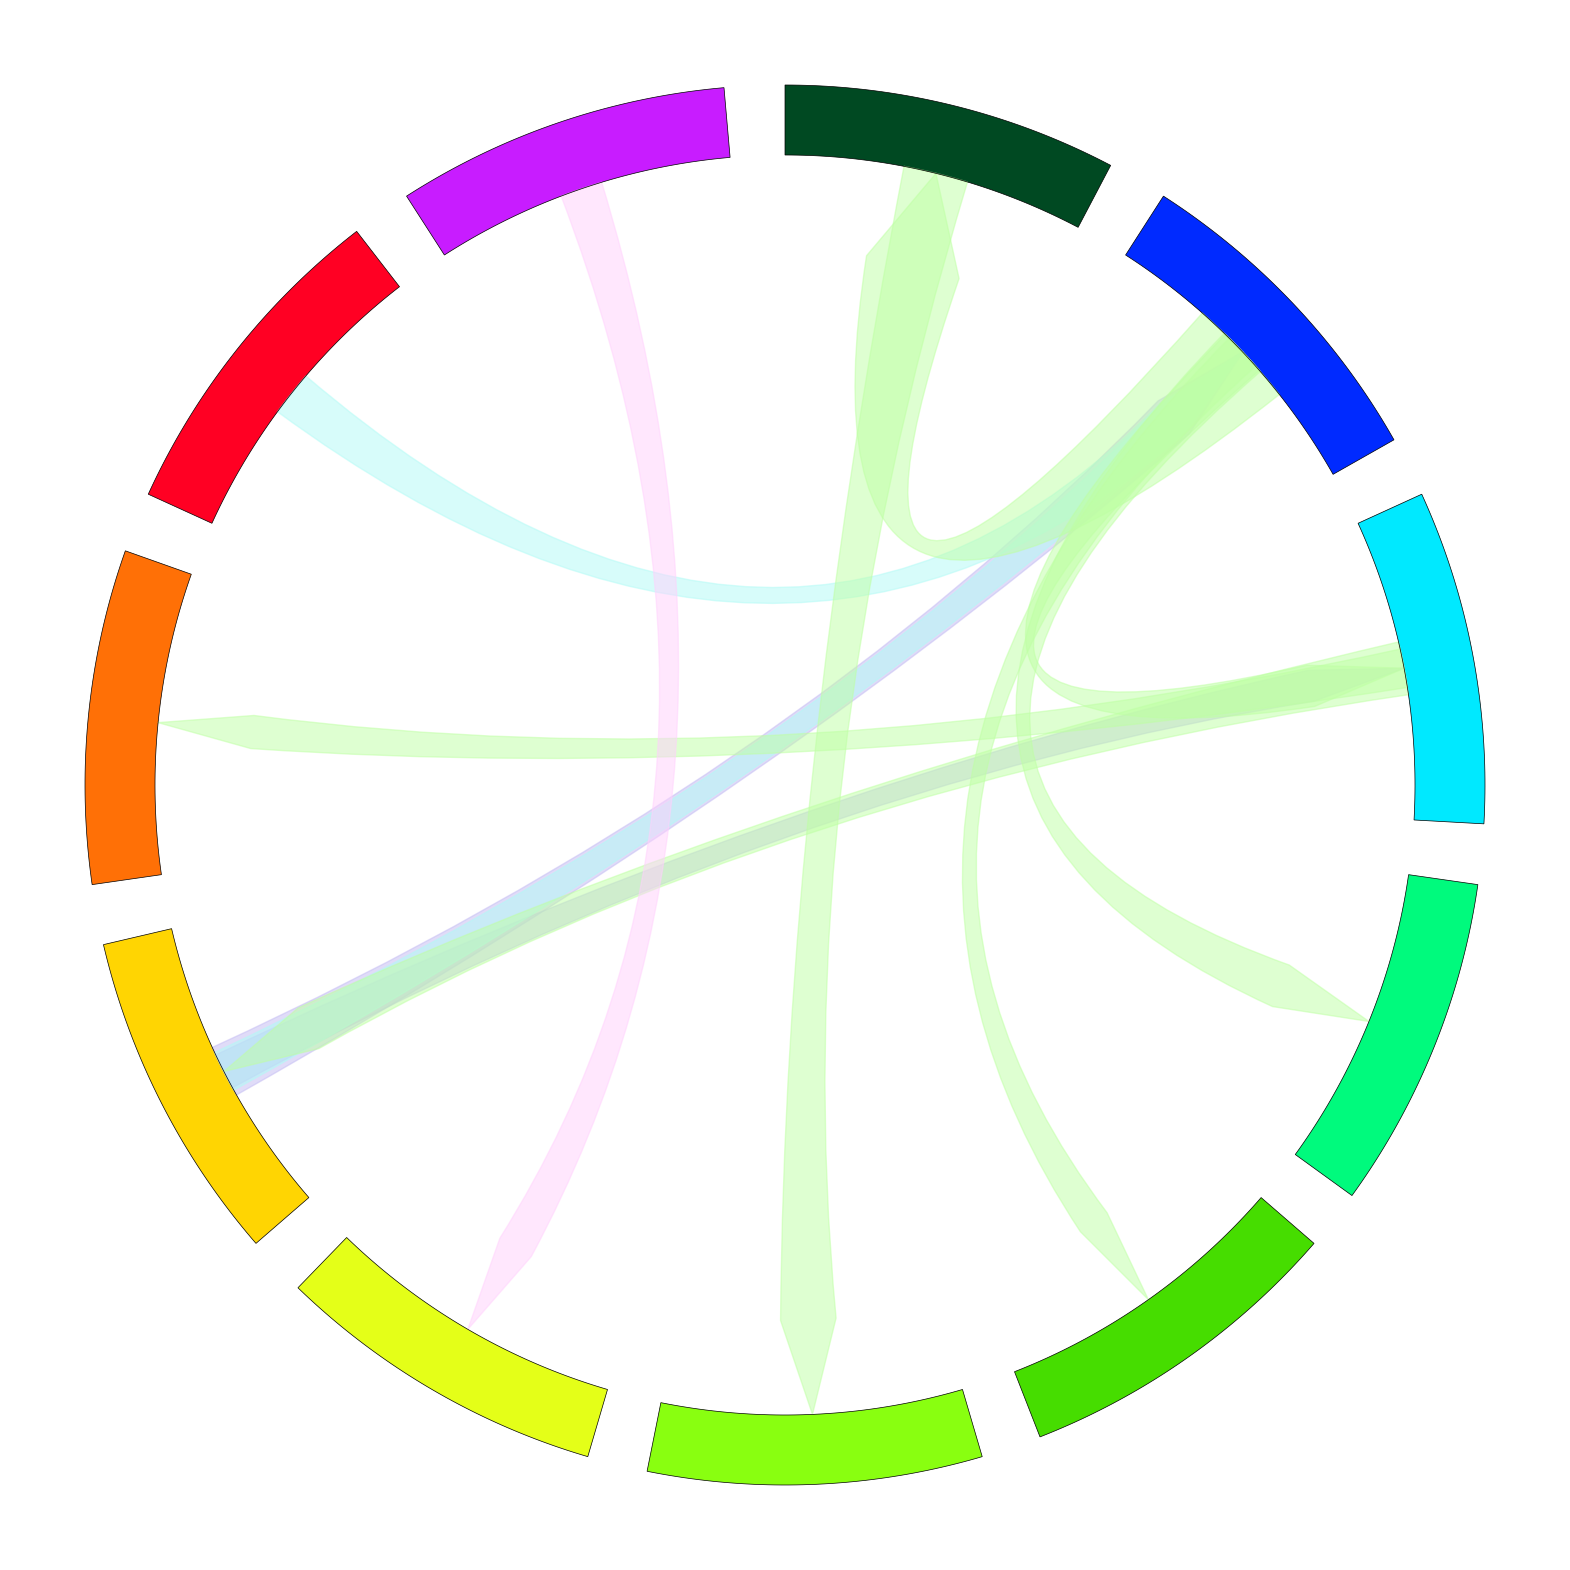

In [637]:
from pycirclize import Circos

from matplotlib import colormaps

#cmap = colormaps.get("tab20")
cmap = colormaps.get("gist_ncar")
color_dict = chebi_lut

sectors = {MAGs_steadycom_dict[mag]:1 for mag in mags_community}
#name2color = phyla_lut

circos = Circos(sectors,space=5)

#vmax = data_df.sum().max()
i = 10
for sector in circos.sectors:
    
    # Add taxonomic group
    track = sector.add_track((90, 100))
    track.axis(fc=cmap(i))
    i+=20

colors_classes = []

for link in links:

    if link[3] in chebi_colors_ser.keys():
        color = chebi_colors_ser[link[3]]
        class_ = chebi_interesting.loc[link[3],"self defined super class"]
    else:
        color = "#eaeaea"
        class_ = "other" 

    circos.link(link[0],link[1],direction=1,color=color,ec=color,lw=1,arrow_length_ratio=0.15,allow_twist=False)#,alpha=alpha)

    colors_classes.append((color,class_))


 ### Plot


fig = circos.plotfig(figsize=(15,15))


colors_classes = list(set(colors_classes))

#plt.title(title,fontsize=30)
